# LOG

03/30/2018: Start working on explain the Starter Code  
03/31/2018: Add functions to complete the code, hardcode goal position  
04/01/2018: Add functions, accepting goal position from arguments  

# Explain the Starter Code
Compare motion_planning.py with backyard_flyer_solution.py side by side and describe in words how each of modifications implemented in motion_planning.py is functioning.

1. States are defined different, using auto()
2. Add PLANNING state in states
3. Replace all_waypoints with waypoints in class initial definition
4. In state_callback(), in Arming state, instead of calling takeoff_transition(), it is calling plan_path()
5. In state_callback(), in Planning state, calliing takeoff_transition()
6. Add new function send_waypoints()
7. Add new function plan_path()

## Import libraries

In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local



In [2]:
import re
import matplotlib.pyplot as plt

## Define functions

In [3]:
def read_home(filepath):
    """
    Read the first line of the csv file
    extract lat0 and lon0 as floating point values
    """
    # Read first line
    with open(filepath) as f:
        first_line = f.readline()
#     print(first_line)
    # Regular expression match
    ret_groups = re.match('^lat0 (.*), lon0 (.*)$', first_line)
#     print(ret_groups.group(1))
    lat0 = float(ret_groups.group(1))
    lon0 = float(ret_groups.group(2))
#     print(type(lon0))
    
    return lat0, lon0

In [4]:
# filepath = 'colliders.csv'
# lat0, lon0 = read_home(filepath)
# print("lat0 is ", lat0)
# print("lon0 is ", lon0)

In [5]:
# Define a simple function to add a z coordinate of 1
def point(p):
    return np.array([p[0], p[1], 1.])

In [6]:
def collinearity_float(p1, p2, p3, epsilon=1e-2): 
    collinear = False
    # TODO: Add a third dimension of z=1 to each point
    p1_new = point(p1)
    p2_new = point(p2)
    p3_new = point(p3)
    
    # TODO: Create the matrix out of three points
    mat = np.vstack((p1_new, p2_new, p3_new))
    
    # TODO: Calculate the determinant of the matrix. 
    det = np.linalg.det(mat)
    
    # TODO: Set collinear to True if the determinant is less than epsilon
    collinear = False
    if np.abs(det) < epsilon:
        collinear = True

    return collinear

In [7]:
def collinearity_int(p1, p2, p3): 
    collinear = False
    # TODO: Calculate the determinant of the matrix using integer arithmetic 
    det = p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])
    
    # TODO: Set collinear to True if the determinant is equal to zero
    if 0 == det:
        collinear = True

    return collinear

In [8]:
def bres(p1, p2): 
    """
    Note this solution requires `x1` < `x2` and `y1` < `y2`.
    """
    x1, y1 = p1
    x2, y2 = p2
    cells = []
    
    # TODO: Determine valid grid cells
    dy = y2 - y1
    dx = x2 - x1
    # y = m*x + b
    # -> dy = m*dx
    # -> m = dy/dx
    m = dy/dx
#     print("m is", m)
    
    # Initial value
    x = x1
    y = y1
    
    # Initial cell value
    x_cell = x1
    y_cell = y1
    
    # Initial line equation result
    f = m
    
    while x < x2 and y < y2:
        cells.append([x_cell, y_cell])
#         print("y is", y)
        
        if f > (y + 1):
            y += 1
            y_cell += 1
#             print("Increase y")
#             print("y is", y)
        elif f == (y + 1):
            if 0: # Set it to 1 for more conservative approach
                cells.append([x_cell + 1, y_cell])
                cells.append([x_cell, y_cell + 1])
            x += 1
            x_cell += 1
            y += 1
            y_cell += 1
            f += m
        else:
            x += 1
            x_cell += 1
            f += m
#             print("Increase x")
#             print("x is", x)
        
        
    return np.array(cells)

In [9]:
def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i + 1])
        p3 = point(pruned_path[i + 2])
        
        # Check if 3 points are in a line
        if collinearity_float(p1, p2, p3):
            # Remove the 2nd point from the path
            pruned_path.remove(pruned_path[i+1])
        else:
            # Move to the next 3 points
            i += 1
    
    return pruned_path

## Define classes

In [10]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()


In [11]:
class MotionPlanning(Drone):

    def __init__(self, connection, global_goal_position=(20, 20, 20)):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL
        self.global_goal_position = global_goal_position

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        filepath = 'colliders.csv'
        lat0, lon0 = read_home(filepath)
        print("Current global home is ({0}, {1}).".format('lat0', 'lon0'))

        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(lon0, lat0, 0)

        # TODO: retrieve current global position
        global_lon, global_lat, global_alt = self.global_position
 
        # TODO: convert to current local position using global_to_local()
        local_north, local_east, local_down = global_to_local(self.global_position, self.global_home)
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        
        # Plot current grid
        print("Plot current grid.")
        plt.rcParams['figure.figsize'] = 12, 12
        # equivalent to
        # plt.imshow(np.flip(grid, 0))
        plt.imshow(grid, origin='lower') 
        
        plt.xlabel('EAST')
        plt.ylabel('NORTH')
        plt.show()
        
        # Define starting point on the grid (this is just grid center)
#         grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        grid_start_north = int(np.ceil(local_north - north_offset))
        grid_start_east = int(np.ceil(local_east - east_offset))
        grid_start = (grid_start_north, grid_start_east)
        
        # Set goal as some arbitrary position on the grid
#         grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert
#         self.global_goal_position = [10, 10, 10] # Change the global goal position
        local_goal_north, local_goal_east, local_goal_down = global_to_local(self.global_goal_position, self.global_home)
        grid_goal_north = int(np.ceil(local_goal_north - north_offset))
        grid_goal_east = int(np.ceil(local_goal_east - east_offset))
        grid_goal = (grid_goal_north, grid_goal_east)

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        
        # Plot founded path on grid
        print("Plot founded path on grid.")
        plt.imshow(grid, cmap='Greys', origin='lower')

        # For the purposes of the visual the east coordinate lay along
        # the x-axis and the north coordinates long the y-axis.
        plt.plot(grid_start[1], grid_start[0], 'x')
        plt.plot(grid_goal[1], grid_goal[0], 'x')

        pp = np.array(path)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

        plt.xlabel('EAST')
        plt.ylabel('NORTH')
        plt.show()
        
        # TODO: prune path to minimize number of waypoints
        pruned_path = prune_path(path)
        
        # Plot pruned path on grid
        print("Plot pruned path on grid.")
        plt.imshow(grid, cmap='Greys', origin='lower')

        plt.plot(grid_start[1], grid_start[0], 'x')
        plt.plot(grid_goal[1], grid_goal[0], 'x')

        pp = np.array(pruned_path)
        plt.plot(pp[:, 1], pp[:, 0], 'g')
        plt.scatter(pp[:, 1], pp[:, 0])

        plt.xlabel('EAST')
        plt.ylabel('NORTH')

        plt.show()
        
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()


In [12]:
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--port', type=int, default=5760, help='Port number')
#     parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
#     parser.add_argument('--global_goal_lon', type=str, default='10', help="Goal position longitude")
#     parser.add_argument('--global_goal_lat', type=str, default='10', help="Goal position latitude")
#     parser.add_argument('--global_goal_alt', type=str, default='10', help="Goal position altitude")
    
#     args = parser.parse_args()
#     %tb
    
#     conn = MavlinkConnection('tcp:{0}:{1}'.format(args.host, args.port), timeout=60)
#     global_goal_position = np.fromstring('{args.global_goal_lon},{args.global_goal_lat},{args.global_goal_alt}', dtype='Float64', sep=',')

    

Logs\TLog.txt
Logs\NavLog.txt
starting connection
arming transition
Searching for a path ...
Current global home is (lat0, lon0).
global home [-122.39745   37.79248    0.     ], position [-1.22397451e+02  3.77924798e+01  4.50000000e-02], local position [-0.01467351 -0.08153246 -0.04545921]
North offset = -316, east offset = -445
Plot current grid.


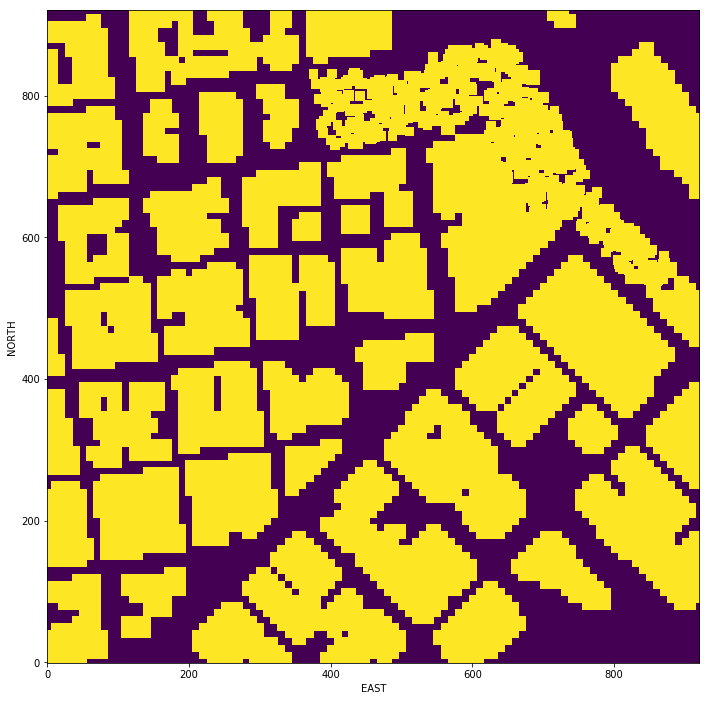

Local Start and Goal:  (316, 445) (787, 46)
Found a path.
Plot founded path on grid.


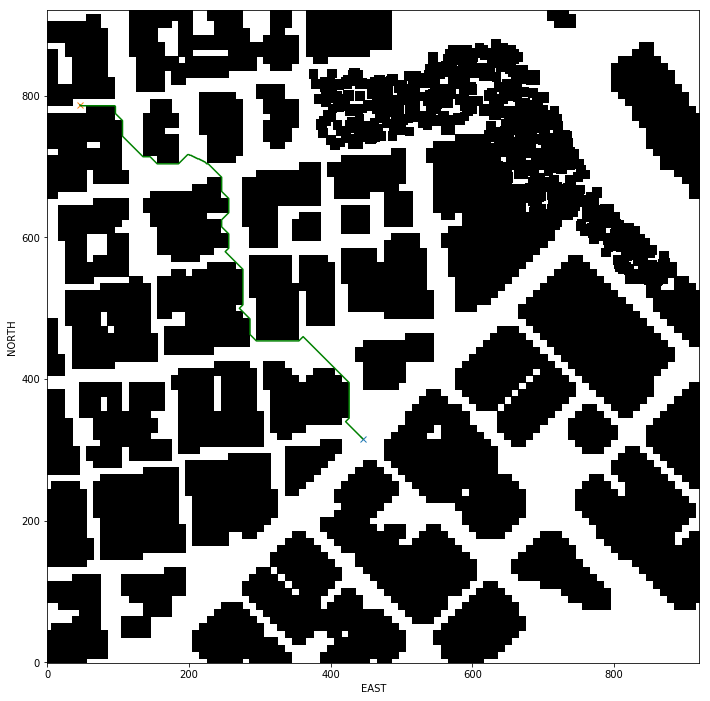

Plot pruned path on grid.


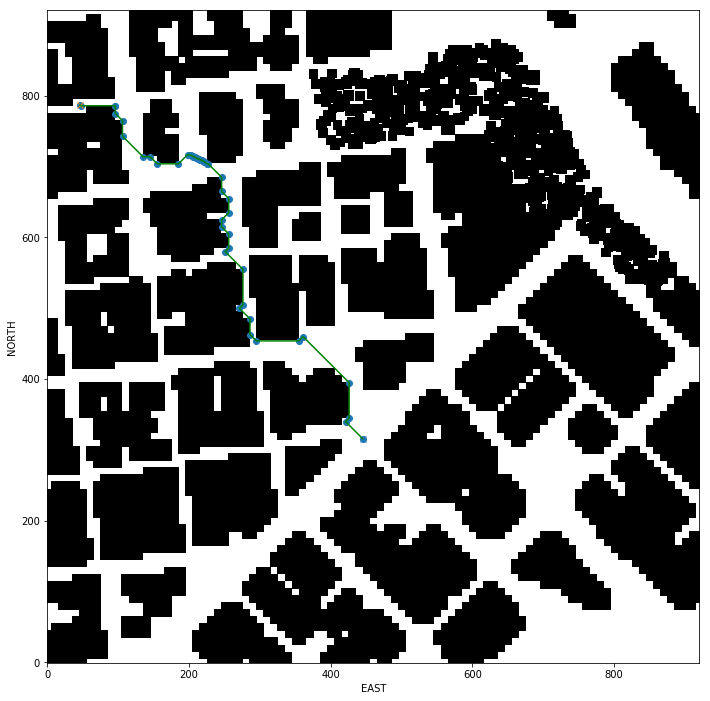

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [24, -24, 5, 0]
waypoint transition
target position [29, -19, 5, 0]
waypoint transition
target position [79, -19, 5, 0]
waypoint transition
target position [144, -84, 5, 0]
waypoint transition
target position [138, -90, 5, 0]
waypoint transition
target position [138, -150, 5, 0]
waypoint transition
target position [147, -159, 5, 0]
waypoint transition
target position [169, -159, 5, 0]
waypoint transition
target position [184, -174, 5, 0]
waypoint transition
target position [189, -169, 5, 0]
waypoint transition
target position [239, -169, 5, 0]
waypoint transition
target position [264, -194, 5, 0]
waypoint transition
target position [269, -189, 5, 0]
waypoint transition
target position [289, -189, 5, 0]
waypoint transition
target position [299, -199, 5, 0]
waypoint transition
target position [309, -199, 5, 0]
waypoint transition
target position [319,

In [13]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)
global_goal_position = (-122.40195876, 37.79673913, -0.147)

drone = MotionPlanning(conn, global_goal_position = global_goal_position)
time.sleep(1)
drone.start()